1. Tải Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huakhonghen","key":"398c355d6c43117f3fd665a764649844"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.74GB/s]


In [4]:
import zipfile
import os

with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_cifake")

print("oke")

oke


In [5]:
!cd dataset_cifake/

2. Xây dựng lớp đọc dữ liệu

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from torchvision import models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


In [8]:
IMG_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = 'dataset_cifake'

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=2)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(dataset_sizes["train"])
print(dataset_sizes["test"])
print(class_names)

100000
20000
['FAKE', 'REAL']


3. CNN

In [11]:
class MyNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MyNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x


In [12]:
net = MyNet().to(device)

4. Loss function và optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=1e-4
)

5. Huấn luyện

In [14]:
num_epochs=10

history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}/{num_epochs}')
  print('-' * 10)

  for phase in ['train', 'test']:
      if phase == 'train': net.train()
      else: net.eval()

      running_loss = 0.0
      corrects = 0

      for inputs, labels in dataloaders[phase]:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
              outputs = net(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              if phase == 'train':
                  loss.backward()
                  optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          corrects += torch.sum(preds == labels.data)

      dataset_size = len(dataloaders[phase].dataset)
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      if phase == 'train':
          history['train_loss'].append(epoch_loss)
          history['train_acc'].append(epoch_acc.cpu().numpy())
      else:
          history['test_loss'].append(epoch_loss)
          history['test_acc'].append(epoch_acc.cpu().numpy())



Epoch 1/10
----------
train Loss: 0.4392 Acc: 0.7929
test Loss: 0.3300 Acc: 0.8553
Epoch 2/10
----------
train Loss: 0.2987 Acc: 0.8740
test Loss: 0.2366 Acc: 0.9017
Epoch 3/10
----------
train Loss: 0.2500 Acc: 0.8982
test Loss: 0.2065 Acc: 0.9191
Epoch 4/10
----------
train Loss: 0.2231 Acc: 0.9107
test Loss: 0.1970 Acc: 0.9217
Epoch 5/10
----------
train Loss: 0.2077 Acc: 0.9174
test Loss: 0.1723 Acc: 0.9319
Epoch 6/10
----------
train Loss: 0.1984 Acc: 0.9216
test Loss: 0.1721 Acc: 0.9350
Epoch 7/10
----------
train Loss: 0.1885 Acc: 0.9259
test Loss: 0.1522 Acc: 0.9410
Epoch 8/10
----------
train Loss: 0.1814 Acc: 0.9288
test Loss: 0.1549 Acc: 0.9405
Epoch 9/10
----------
train Loss: 0.1754 Acc: 0.9328
test Loss: 0.1532 Acc: 0.9388
Epoch 10/10
----------
train Loss: 0.1708 Acc: 0.9344
test Loss: 0.1390 Acc: 0.9462


6. Lưu

1. Đã lưu mô hình thành công vào: custom_cnn_cifake.pth

2. Đang vẽ biểu đồ huấn luyện...


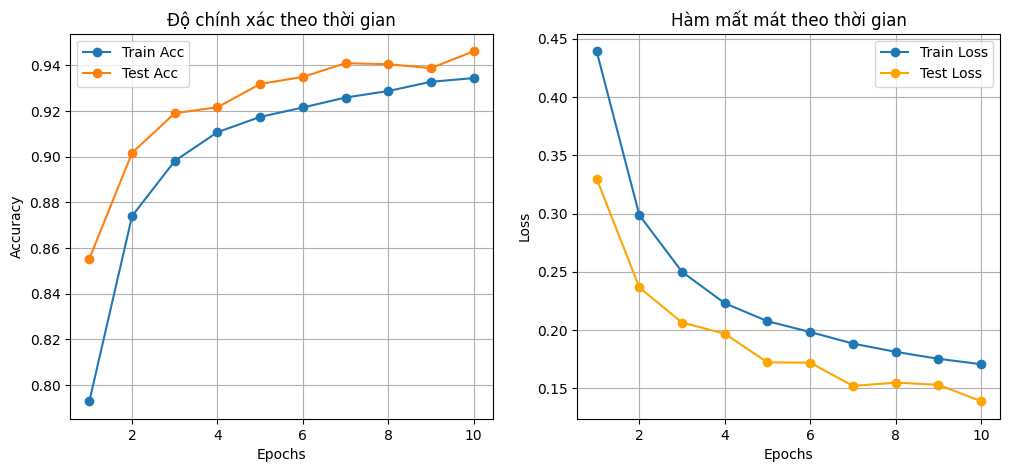

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

SAVE_PATH = 'custom_cnn_cifake.pth'
torch.save(net.state_dict(), SAVE_PATH)
print(f"1. Đã lưu mô hình thành công vào: {SAVE_PATH}")


print("\n2. Đang vẽ biểu đồ huấn luyện...")
epochs_range = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o')
plt.plot(epochs_range, history['test_acc'], label='Test Acc', marker='o')
plt.title('Độ chính xác theo thời gian')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o', color='orange')
plt.title('Hàm mất mát theo thời gian')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

7. Test

In [17]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os

def test_random_10_images(model_path=SAVE_PATH):

    model_test = MyNet().to(device)
    model_test.load_state_dict(torch.load(model_path, map_location=device))
    model_test.eval()

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    test_dir = 'dataset_cifake/test'
    all_images = []

    for root, dirs, files in os.walk(test_dir):
        for f in files:
            if f.lower().endswith(('.jpg','.png','.jpeg')):
                all_images.append(os.path.join(root,f))

    if len(all_images)==0:
        print("Không tìm thấy ảnh test!")
        return

    selected = random.sample(all_images, min(10,len(all_images)))

    plt.figure(figsize=(15,7))
    class_names = ["FAKE","REAL"]

    for i, img_path in enumerate(selected):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model_test(img_tensor)
            probs = F.softmax(outputs, dim=1)
            conf, idx = torch.max(probs,1)

        pred_label = class_names[idx.item()]
        conf_score = conf.item()*100

        folder = os.path.basename(os.path.dirname(img_path)).upper()
        true_label = "FAKE" if "FAKE" in folder else "REAL"

        color = "green" if pred_label==true_label else "red"

        plt.subplot(2,5,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {conf_score:.1f}%",
                  color=color,fontweight="bold")

    plt.tight_layout()
    plt.show()


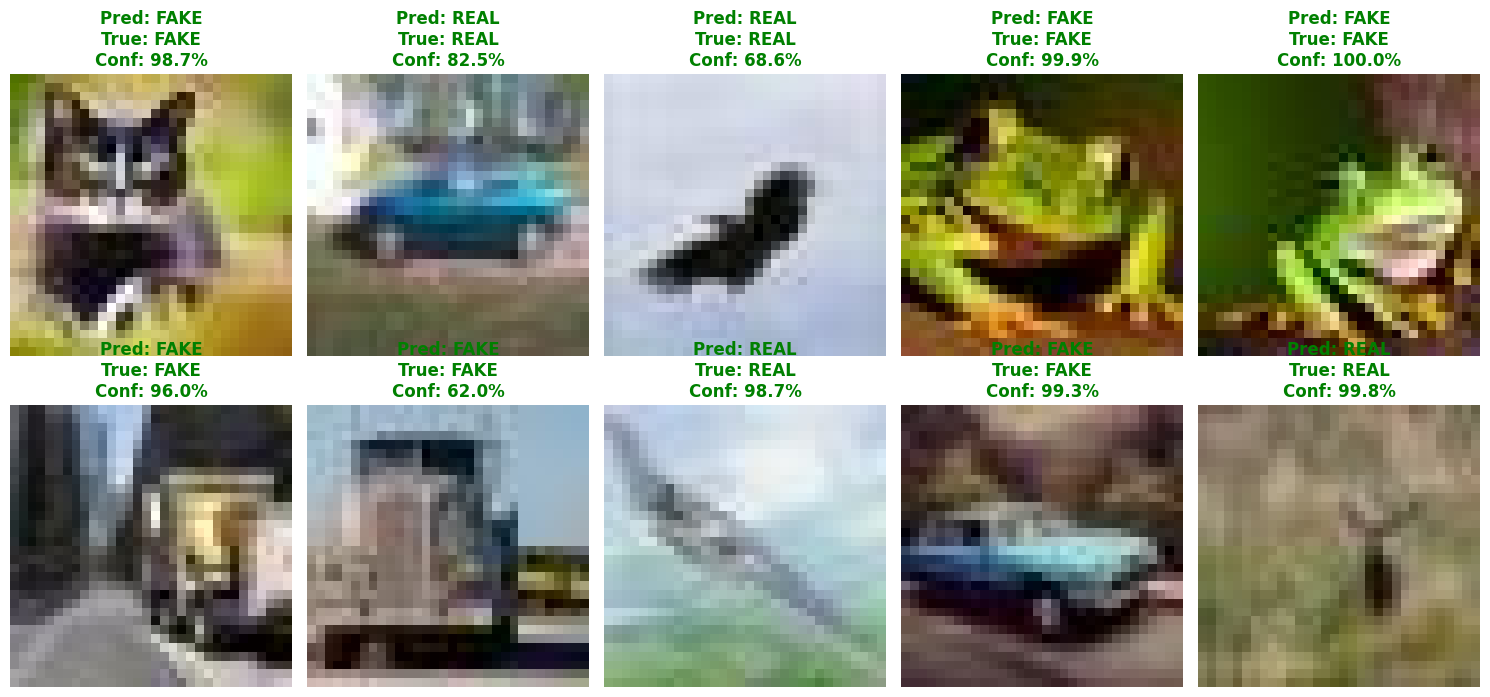

In [24]:
test_random_10_images()
